# Power spectrum covariance matrix plots (analytic and EZmocks-based)

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

sys.path.append('../bin')
from cov_utils import truncate_cov, get_EZmocks_covariance, cov_to_corrcoef

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# tracer
tracer = 'ELG_LOPnotqso'
region = 'SGC'
completeness = True
zmin = 0.8
zmax = 1.1

# multipoles
ells = (0, 2, 4)
klim = (0., 0.4)
krebin = 5

# cut
rpcut = 0
thetacut = 0.05

### Load covariance

In [3]:
# Analytic
analytic_cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/cov_gaussian_pre_{}_{}_{:.1f}_{:.1f}_default_FKP_lin.txt'.format(tracer, region, zmin, zmax)
analytic_cov = np.loadtxt(analytic_cov_fn)
analytic_cov = truncate_cov(analytic_cov, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(klim[0], klim[1], 0.005))
analytic_corrcoef = cov_to_corrcoef(analytic_cov)

# EZmocks
ezmocks_cov = get_EZmocks_covariance(stat='pkpoles', tracer=tracer, region=region, zrange=(zmin, zmax), completeness='ffa', ells=(0, 2, 4), rpcut=rpcut, thetacut=thetacut, rebin=krebin, return_x=False)
ezmocks_cov = truncate_cov(ezmocks_cov, kinit=np.arange(0., 0.520, 0.005), kfinal=np.arange(klim[0], klim[1], 0.005))
ezmocks_corrcoef = cov_to_corrcoef(ezmocks_cov)

940
523


In [32]:
def plot_corrcoef(cov, ells, k, norm=None):
    stddev = np.sqrt(np.diag(cov).real)
    corrcoef = cov / stddev[:, None] / stddev[None, :]

    nk = len(k)
    nells = len(ells)

    fig, lax = plt.subplots(nrows=nells, ncols=nells, sharex=False, sharey=False, figsize=(5, 4), squeeze=False)
    #fig.subplots_adjust(wspace=0.1, hspace=0.1)

    from matplotlib import colors
    norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1) if norm is None else norm

    for i in range(nells):
        for j in range(nells):
            ax = lax[nells-1-i][j]
            mesh = ax.pcolor(k, k, corrcoef[i*nk:(i+1)*nk,j*nk:(j+1)*nk].T, norm=None, cmap=plt.get_cmap('RdBu'))
            if i>0: ax.xaxis.set_visible(False)
            else: ax.set_xlabel(r'$k$  [$h$/Mpc]')
            if j>0: ax.yaxis.set_visible(False)
            else: ax.set_ylabel(r'$k$  [$h$/Mpc]')
            text = r'{} $\times$ {}'.format(r'$\ell={}$'.format(ells[j % nells]), r'$\ell={}$'.format(ells[i]))
            ax.text(0.05, 0.95, text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black')
            ax.grid(False)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.01, 0.14, 0.03, 0.82])
    cbar = fig.colorbar(mesh, cax=cbar_ax)
    cbar.set_label(r'$r$', rotation=90)
    return lax

/tmp/ipykernel_835682/3308643128.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


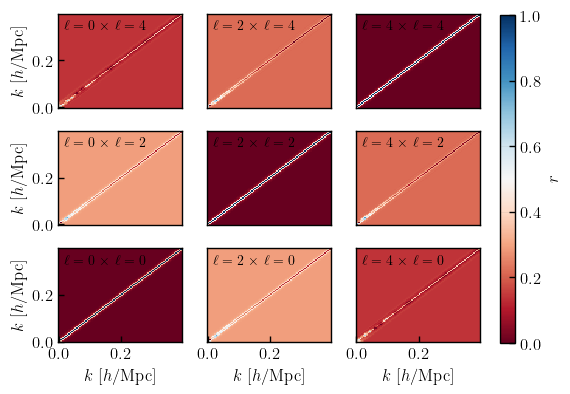

In [33]:
plot_corrcoef(analytic_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.tight_layout()
plt.show()

/tmp/ipykernel_835682/4245117699.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


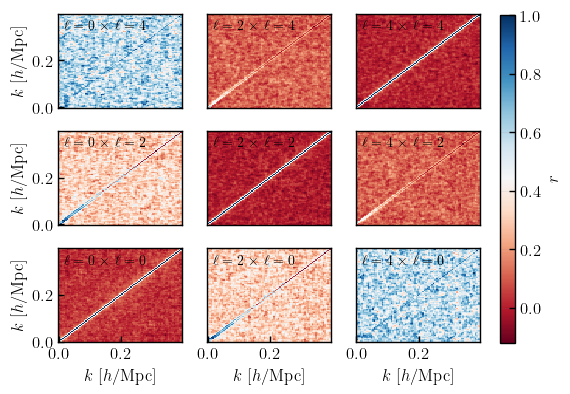

In [34]:
plot_corrcoef(ezmocks_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.tight_layout()
plt.show()

In [12]:
### Add artificial noise to the analytical covariance
from numpy import random

fake_data = random.multivariate_normal(np.zeros(analytic_cov.shape[0]), analytic_cov, size=1000)

/tmp/ipykernel_835682/186405203.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  fake_data = random.multivariate_normal(np.zeros(analytic_cov.shape[0]), analytic_cov, size=1000)


In [26]:
noisy_cov = np.cov(fake_data, rowvar=False, ddof=1)

# Hartlap correction
nmocks = 1000
nk = analytic_cov.shape[0]
hartlap = (nmocks - nk - 2) / (nmocks - 1)
noisy_cov /= hartlap

noisy_cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/noisy_cov_gaussian_pre_{}_{}_{:.1f}_{:.1f}_default_FKP_lin.txt'.format(tracer, region, zmin, zmax)
np.savetxt(noisy_cov_fn, noisy_cov)

/tmp/ipykernel_835682/653146050.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


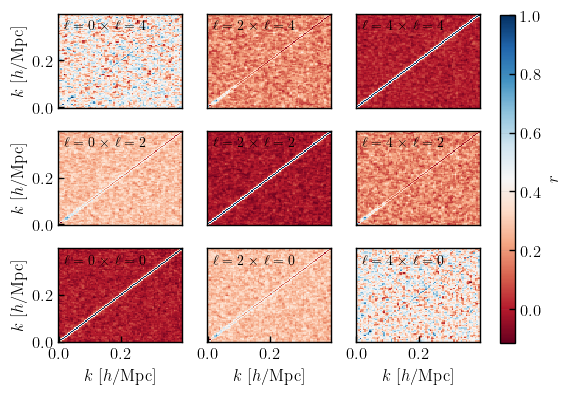

In [35]:
plot_corrcoef(noisy_cov, ells, np.arange(klim[0], klim[1], 0.005))
plt.tight_layout()
plt.show()